In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [82]:
df = pd.read_csv("./../input/ETHUSDT_1d_join_final.csv")

for col in df.columns:
    print(col)

df.head()

date
open
high
low
close
volume
base_asset_volume
no_trades
taker_buy_vol
taker_buy_base_asset_vol


,date,open,high,low,close,volume,base_asset_volume,no_trades,taker_buy_vol,taker_buy_base_asset_vol
0,1/01/2020,129.16,133.05,128.68,130.77,144770.5220,18952318.53,75888,71847.93883,9.407940e+06
1,2/01/2020,130.72,130.78,126.38,127.19,213757.0581,27486853.39,96193,105830.56190,1.361506e+07
2,3/01/2020,127.19,135.14,125.88,134.35,413055.1890,54139288.22,162310,227899.25530,2.986355e+07
3,4/01/2020,134.37,135.85,132.50,134.20,184276.1710,24641135.57,95488,85809.67556,1.147696e+07
4,5/01/2020,134.20,138.19,134.19,135.37,254120.4534,34593687.60,115106,126786.52060,1.726044e+07


date: the trading day
open: the price at 00:00 on the trading day
high: the highest price obtained on the date
low: the lowest price obtained on the date
close: the price at 23:59 (or right before 00:00 of the next day)
volume: number of coins traded on the date
base_asset_volume: amount traded for all orders in USD
no_trades: the number of trades executed on the date
taker_buy_vol: number of coins bought by market takers on the date
taker_buy_base_asset_vol: amount bought by marker takers in USD

# Data visualisation + Feature Engineering

In [85]:
# feature engineering

# Volume Weighted Average Price (VWAP)
df['VWAP'] = (((df['high'] + df['low'] + df['close']) / 3) * df['volume']).cumsum() / df['volume'].cumsum()

# exponential moving average of price
def exponential_moving_average(prices, period, weighting_factor=0.2):
    ema = np.zeros(len(prices))
    sma = np.mean(prices[:period])
    ema[period - 1] = sma
    for i in range(period, len(prices)):
        ema[i] = (prices[i] * weighting_factor) + (ema[i - 1] * (1 - weighting_factor))
    return ema

period = 5
weighting = 0.2
ema = exponential_moving_average(np.divide(np.add(np.add(df['high'], df['low']), df['close']),3), period, weighting)

df['ema'] = ema
df['ema'] = df['ema'].replace(0, pd.NA)

# average true range (volatility indicator)
def true_range(open, high, low, close):
    tr = np.zeros(len(open))
    for idx in range(1, len(open)):
        H = high[idx]
        L = low[idx]
        C_p = close[idx - 1]
        tr[idx] = max(max(abs(H-L), abs(H-C_p)), abs(L-C_p))
    return tr

tr = true_range(df['open'], df['high'], df['low'], df['close'])
print(tr)

def average_true_range(tr, period):
    atr = np.zeros(len(tr))
    atr[period] = np.mean(tr[1:period-1])
    for idx in range(period+1, len(tr)):
        atr[idx] = (atr[idx-1] + tr[idx]) / period
    return atr

df['atr'] = average_true_range(tr, period=14)
df['atr'] = df['atr'].replace(0, pd.NA)

df = df.dropna()
print(df.info())

df.head()

[  0.     4.4    9.26 ... 130.07  54.84  62.46]
<class 'pandas.core.frame.DataFrame'>
Index: 1507 entries, 14 to 1520
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      1507 non-null   object 
 1   open                      1507 non-null   float64
 2   high                      1507 non-null   float64
 3   low                       1507 non-null   float64
 4   close                     1507 non-null   float64
 5   volume                    1507 non-null   float64
 6   base_asset_volume         1507 non-null   float64
 7   no_trades                 1507 non-null   int64  
 8   taker_buy_vol             1507 non-null   float64
 9   taker_buy_base_asset_vol  1507 non-null   float64
 10  VWAP                      1507 non-null   float64
 11  ema                       1507 non-null   object 
 12  atr                       1507 non-null   object 
dtypes: float64(9), int6

,date,open,high,low,close,volume,base_asset_volume,no_trades,taker_buy_vol,taker_buy_base_asset_vol,VWAP,ema,atr
14,15/01/2020,165.60,171.98,159.20,166.40,721687.8038,1.192399e+08,251183,350727.9639,57992191.98,146.274725,149.180743,6.619167
15,16/01/2020,166.40,167.40,157.80,164.21,456170.8672,7.403865e+07,179108,221669.3963,35985561.13,147.457383,151.971928,1.158512
16,17/01/2020,164.24,174.81,162.14,169.85,767180.6785,1.299093e+08,273867,375143.0151,63553850.73,149.723328,155.364209,0.987751
17,18/01/2020,169.92,179.50,164.92,174.14,688783.1798,1.193883e+08,240660,350447.0151,60783310.67,151.724806,158.862034,1.111982
18,19/01/2020,174.10,178.05,161.66,166.79,624681.2860,1.056914e+08,203953,307350.6395,51957534.85,152.969757,160.856294,1.250142


/tmp/ipykernel_76501/1892568947.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


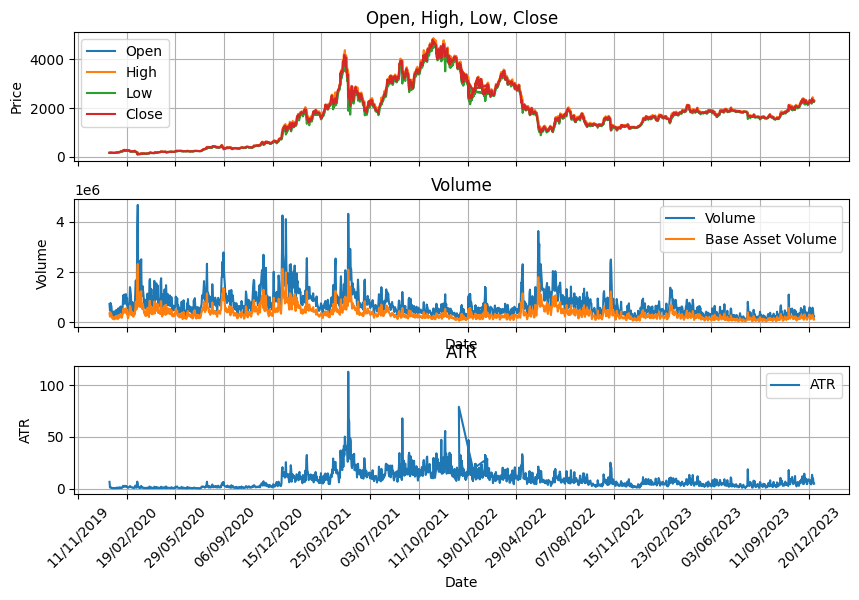

In [78]:
# plotting
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Create a figure with two subplots sharing the x-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6), sharex=True, gridspec_kw={'hspace': 0.3})

# Plot Open, High, Low, Close on the first subplot
ax1.plot(df['date'], df['open'], label='Open')
ax1.plot(df['date'], df['high'], label='High')
ax1.plot(df['date'], df['low'], label='Low')
ax1.plot(df['date'], df['close'], label='Close')

ax1.set_ylabel('Price')
ax1.set_title('Open, High, Low, Close')
ax1.legend()
ax1.grid(True)

# Format x-axis for the first subplot
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=100))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))

# Plot Volume and Taker Buy Volume on the second subplot
ax2.plot(df['date'], df['volume'], label='Volume')
ax2.plot(df['date'], df['taker_buy_vol'], label='Base Asset Volume')

ax2.set_xlabel('Date')
ax2.set_ylabel('Volume')
ax2.set_title('Volume')
ax2.legend()
ax2.grid(True)

# Format x-axis for the second subplot
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=100))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))

# plot atr for the third subplot
ax3.plot(df['date'], df['atr'], label='ATR')

ax3.set_xlabel('Date')
ax3.set_ylabel('ATR')
ax3.set_title('ATR')
ax3.legend()
ax3.grid(True)

ax3.xaxis.set_major_locator(mdates.DayLocator(interval=100))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))


plt.xticks(rotation=45)

plt.tight_layout()

plt.show()


In [87]:
# correlation matrix
corr = df.loc[:, df.columns != 'date'].corr()
corr.style.background_gradient(cmap='coolwarm')


,open,high,low,close,volume,base_asset_volume,no_trades,taker_buy_vol,taker_buy_base_asset_vol,VWAP,ema,atr
open,1.000000,0.998664,0.997036,0.996450,-0.239442,0.539098,0.458878,-0.239716,0.539240,0.586550,0.995102,0.660823
high,0.998664,1.000000,0.996679,0.998243,-0.222462,0.557112,0.478104,-0.221679,0.558446,0.579626,0.994982,0.676813
low,0.997036,0.996679,1.000000,0.998179,-0.275576,0.499638,0.422029,-0.274481,0.501440,0.596406,0.991918,0.617093
close,0.996450,0.998243,0.998179,1.000000,-0.246710,0.529858,0.452649,-0.244980,0.532369,0.584618,0.992737,0.647864
volume,-0.239442,-0.222462,-0.275576,-0.246710,1.000000,0.547934,0.605514,0.998997,0.547108,-0.374604,-0.235492,0.326885
base_asset_volume,0.539098,0.557112,0.499638,0.529858,0.547934,1.000000,0.955502,0.548264,0.999250,0.165717,0.541437,0.865478
no_trades,0.458878,0.478104,0.422029,0.452649,0.605514,0.955502,1.000000,0.606790,0.956219,0.181219,0.460476,0.802320
taker_buy_vol,-0.239716,-0.221679,-0.274481,-0.244980,0.998997,0.548264,0.606790,1.000000,0.548814,-0.373332,-0.235669,0.324772
taker_buy_base_asset_vol,0.539240,0.558446,0.501440,0.532369,0.547108,0.999250,0.956219,0.548814,1.000000,0.166952,0.541727,0.862406
VWAP,0.586550,0.579626,0.596406,0.584618,-0.374604,0.165717,0.181219,-0.373332,0.166952,1.000000,0.599540,0.220042
